In [349]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import pythermalcomfort.psychrometrics as pp


In [350]:
df = pd.read_csv('CN_DB.csv')
df.columns

Index(['suject_id', 'timestamp', 'season', 'city', 'climate', 'building_type',
       'heating_type', 'gender', 'age', 'ht', 'wt', 'thermal_sensation',
       'thermal_comfort', 'thermal_acceptability', 'clo', 'met', 'ta', 'rh',
       'vel', 'tg', 'top', 'tr', 't_out_min', 't_out_monthly', 'latitude',
       'age_group'],
      dtype='object')

(array([ 444.,  686., 3310., 7838., 2415., 1121.,  178.]),
 array([-3, -2, -1,  0,  1,  2,  3,  4]),
 <BarContainer object of 7 artists>)

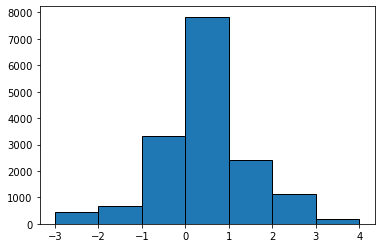

In [381]:
# plot the distribution of thermal sensation votes, the x-axis is from -3 to 3
plt.hist(df['thermal_sensation'], bins=np.arange(-3, 5, 1), edgecolor='black')

(array([   0., 8280., 4530., 1434.,  224.,   15.]),
 array([0, 1, 2, 3, 4, 5, 6]),
 <BarContainer object of 6 artists>)

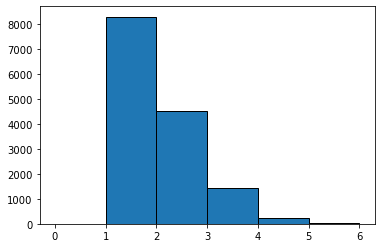

In [380]:
# plot the distribution of thermal comfort votes, the x-axis is from -3 to 3
plt.hist(df['thermal_comfort'], bins=np.arange(0, 7, 1), edgecolor='black')

(array([ 325., 1202., 4984.,  297., 6075.]),
 array([-1. , -0.5,  0. ,  0.5,  1. ,  1.5]),
 <BarContainer object of 5 artists>)

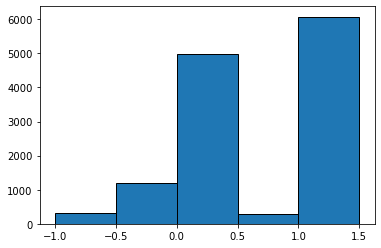

In [386]:
# plot the distribution of thermal acceptability votes, the x-axis is from -3 to 3
plt.hist(df['thermal_acceptability'], bins=np.arange(-1, 2, 0.5), edgecolor='black')

In [351]:
# calculate the wet bulb globe temperature for each reclrd using pp.t_wb()
df['twb'] = df.apply(lambda x: pp.t_wb(tdb=x['ta'], rh=x['rh']), axis=1)

In [352]:
# calcualte the mean values for each city
# group by city, using mean values
df_city = df.groupby('city').agg(
    records=('city', 'size'),
    top=('top', 'mean'),
    top_std=('top', 'std'),
    rh=('rh', 'mean'),
    rh_std=('rh', 'std'),
    vel=('vel', 'mean'),
    met=('met', 'mean'),
    clo=('clo', 'mean'),
    clo_std=('clo', 'std'),
    tsv=('thermal_sensation', 'mean'),
    tcv=('thermal_comfort', 'mean'),
    t_out=('t_out_monthly', 'mean'),
    latitude=('latitude', 'mean'),
).reset_index()

In [353]:
# calculate the percentage of thermal satisfaction, which is tsv between +-1.5 in df, then merge it with df_city
df['satisfied'] = df['thermal_sensation'].apply(lambda x: 1 if x >= -1 and x <= 1 else 0)
df_satisfied = df.groupby('city').agg(
    tsr=('satisfied', 'mean')
).reset_index()
df_city = pd.merge(df_city, df_satisfied, on='city')

In [354]:
df_city

,city,records,tsv,tcv,tav,ta,ta_std,twb,twb_std,rh,...,met,clo,clo_std,top,tg,tr,tr_std,t_out,latitude,tsr
0,Baotou,303,0.016502,1.465347,0.345183,19.766997,3.668882,11.439934,3.648136,36.356436,...,1.069967,0.341782,0.165262,19.277228,19.180198,18.787459,3.653870,-8.600000,40.65,0.900990
1,Beijing,651,-0.027957,1.569800,0.320480,22.948541,2.556381,12.572657,2.624088,28.614439,...,1.056989,0.920568,0.445661,22.066052,22.468971,21.981720,3.733638,5.805036,39.90,0.864823
2,FujianFuzhou,7,-0.714286,1.571429,0.328571,18.100000,1.529706,14.228571,2.013053,67.428571,...,0.885714,0.351429,0.166276,18.100000,18.100000,18.100000,1.529706,NaN,26.08,0.857143
3,FujianNanping,4,0.000000,1.000000,0.325000,17.900000,1.240967,13.150000,1.320353,60.250000,...,0.875000,0.417500,0.097425,17.900000,17.900000,17.900000,1.240967,NaN,26.64,1.000000
4,FujianZhenjiang,2,-0.500000,1.500000,0.550000,22.900000,2.262742,19.550000,2.050610,74.500000,...,0.900000,0.305000,0.332340,22.900000,22.900000,22.900000,2.262742,NaN,26.10,0.500000
5,GuangdongGuangzhou,997,-0.013039,1.377131,0.462588,23.850150,1.077179,17.397593,1.540287,52.936810,...,1.000000,0.859910,0.216484,23.876128,23.879338,23.901204,1.105053,16.710933,23.13,0.900702
6,HainanSanya,5,0.600000,1.600000,0.420000,24.880000,1.243785,20.840000,0.820366,70.200000,...,0.980000,0.332000,0.093381,24.880000,24.880000,24.880000,1.243785,NaN,18.25,0.800000
7,HebeiHandan,26,-0.384615,1.192308,0.853846,19.576923,3.739659,11.238462,2.307739,35.807692,...,0.980769,1.447692,0.298091,19.300000,20.061538,20.061538,3.396242,3.176923,36.62,0.923077
8,HeilongjiangHarbin,3552,0.293300,1.623226,0.749831,23.085107,2.517221,13.469369,2.406216,32.613457,...,1.006447,0.923361,0.323996,22.707995,21.383671,22.562021,2.929839,-7.171811,45.75,0.821227
9,HenanJiaozuo,888,-0.255631,1.388514,NaN,16.798874,4.107372,10.674887,3.179101,49.043919,...,1.100000,1.188874,0.373399,16.798874,16.798874,16.798874,4.107372,NaN,35.24,0.983108


In [355]:
# check the timestamp of cities that miss tout data
for i in df_city[df_city.t_out.isna()]['city']:
    print(i)
    print(df[df['city'] == i]['timestamp'])
    print("###################")

FujianFuzhou
15473     2/6/21 11:16
15481     2/7/21 11:01
15492     2/8/21 16:32
15497     2/9/21 16:44
15513    2/17/21 23:52
15526    2/19/21 16:31
15536    2/20/21 16:30
Name: timestamp, dtype: object
###################
FujianNanping
15482     2/7/21 11:01
15490     2/8/21 11:06
15527    2/19/21 17:15
15560    2/24/21 11:01
Name: timestamp, dtype: object
###################
FujianZhenjiang
15465    2/3/21 21:55
15466    2/4/21 10:48
Name: timestamp, dtype: object
###################
HainanSanya
15433     1/23/21 9:15
15436    1/23/21 11:46
15439    1/23/21 16:46
15441     1/24/21 9:40
15455    1/27/21 14:06
Name: timestamp, dtype: object
###################
HenanJiaozuo
9774      2/25/10 7:30
9775     2/25/10 12:30
9776     2/25/10 20:15
9777      2/26/10 7:20
9778     2/26/10 12:30
             ...      
10657    2/27/10 13:50
10658    2/27/10 21:05
10659     2/28/10 8:16
10660    2/28/10 13:42
10661    2/28/10 21:05
Name: timestamp, Length: 888, dtype: object
###################

## calcualte the neutral temperature for each city using three methods

In [356]:
def regression_a(df):
    """
    tsv = a * top + b
    Regressing Thermal Sensation Vote (tsv) against indoor operative temperature (top).    
    Use the regression model to derive the neutral temperature by letting tsv equals 0.
    The upper and lower limit of 80% comfort zone are derived by letting tsv equals +-0.85.
    """
    lm_result = smf.ols(formula='tsv ~ top', data=df).fit()
    slope = lm_result.params['top']
    intercept = lm_result.params['Intercept']
    # check whether the slope is significant
    if lm_result.pvalues['top'] < 0.05:
        a = slope
        b = intercept
        tn = -b / a
        tup = (0.85-b)/a
        tlow = (-0.85-b)/a
        comfz = tup - tlow
        return [tn, comfz]
    else:
        return [np.nan] * 2  # Return NaNs if the slope is not significant

def regression_b(df):
    """
    top = a * tsv + b
    Regressing indoor operative temperature (top) against tsv.
    Use the regression model to derive the neutral temperature by letting tsv equals 0.
    The upper and lower limit of 80% comfort zone are derived by letting tsv equals +-0.85.
    """
    lm_result = smf.ols(formula='top ~ tsv', data=df).fit()
    slope = lm_result.params['tsv']
    intercept = lm_result.params['Intercept']
    # check whether the slope is significant
    if lm_result.pvalues['tsv'] < 0.05:
        a = slope
        b = intercept
        tn = b
        tup = 0.85*a + b
        tlow = (-0.85)*a + b
        comfz = tup - tlow
        return [tn, comfz]
    else:
        return [np.nan] * 2
    
def griffiths(df):
    # Nicol, Fergus, and Michael Humphreys. “Derivation of the Adaptive Equations for Thermal Comfort in Free-Running Buildings in European Standard EN15251.” Building and Environment, International Symposium on the Interaction between Human and Building Environment Special Issue Section, 45, no. 1 (January 1, 2010): 11–17. https://doi.org/10.1016/j.buildenv.2008.12.013.
    # Griffths I. Thermal comfort studies in buildings with passive solar features, field studies. UK: Report of the Commission of the European Community, ENS35 090; 1990.
    # Tcomf = Tg - C / G, c as comfort vote and G as griffiths constatnt
    tn = df['tg'] - df['tsv'] / 0.4
    return tn


In [357]:
# # apply regression_a to df for each city and store the results in the df_city
# result = df.groupby('city').apply(regression_a)
# df_result = pd.DataFrame(result.tolist(), index=result.index, columns=['tn_a', 'comfz_a'])
# df_city = df_city.merge(df_result, left_on='city', right_index=True, how='left')

# # apply regression_b to df for each city and store the results in the df_city
# result = df.groupby('city').apply(regression_b)
# df_result = pd.DataFrame(result.tolist(), index=result.index, columns=['tn_b', 'comfz_b'])
# df_city = df_city.merge(df_result, left_on='city', right_index=True, how='left')
# df_city

# directly apply griffiths to df for each city and store the results in the df_city
df_city['tn_op'] = df_city['top'] - df_city['tsv'] / 0.4

## Likelihood of Central Heating by City


In [358]:
# check the heating_type unique values
print(df['heating_type'].unique())

['Radiator heating' 'Convection heating' 'Radiant floor heating'
 'Naturally Ventilated' 'Ceiling capillary heating'
 'Air conditioning heating' 'Others' 'self-heating' 'Furnace heating'
 'Floor radiation + fan coil' 'Small electric heater heating']


In [359]:
# calcualte the percentage of Radiator heating for each city and assign the value to df_city
df_city['p_dh'] = df_city['city'].apply(lambda x: df[df['city'] == x]['heating_type'].value_counts().get('Radiator heating', 0) / df[df['city'] == x]['heating_type'].count())

In [360]:
# resort the df_city by latitude
df_city = df_city.sort_values(by='latitude')
# reset the index
df_city = df_city.reset_index(drop=True)
df_city

,city,records,tsv,tcv,tav,ta,ta_std,twb,twb_std,rh,...,clo_std,top,tg,tr,tr_std,t_out,latitude,tsr,tn_op,p_dh
0,HainanSanya,5,0.600000,1.600000,0.420000,24.880000,1.243785,20.840000,0.820366,70.200000,...,0.093381,24.880000,24.880000,24.880000,1.243785,NaN,18.25,0.800000,23.380000,0.000000
1,GuangdongGuangzhou,997,-0.013039,1.377131,0.462588,23.850150,1.077179,17.397593,1.540287,52.936810,...,0.216484,23.876128,23.879338,23.901204,1.105053,16.710933,23.13,0.900702,23.908726,0.000000
2,YunnanKunming,415,-1.154217,1.424242,0.687879,13.617108,3.116982,4.407711,3.788960,16.946988,...,0.250786,13.617108,19.218182,13.617108,3.116982,NaN,24.87,0.660241,16.502651,0.000000
3,FujianFuzhou,7,-0.714286,1.571429,0.328571,18.100000,1.529706,14.228571,2.013053,67.428571,...,0.166276,18.100000,18.100000,18.100000,1.529706,NaN,26.08,0.857143,19.885714,0.000000
4,FujianZhenjiang,2,-0.500000,1.500000,0.550000,22.900000,2.262742,19.550000,2.050610,74.500000,...,0.332340,22.900000,22.900000,22.900000,2.262742,NaN,26.10,0.500000,24.150000,0.000000
5,FujianNanping,4,0.000000,1.000000,0.325000,17.900000,1.240967,13.150000,1.320353,60.250000,...,0.097425,17.900000,17.900000,17.900000,1.240967,NaN,26.64,1.000000,17.900000,0.000000
6,HunanHengyang,1,-1.000000,2.000000,-0.100000,16.900000,NaN,12.900000,NaN,66.000000,...,NaN,16.900000,16.900000,16.900000,NaN,NaN,26.89,1.000000,19.400000,0.000000
7,HunanChangsha,1108,-0.396029,2.816697,0.414621,17.222563,3.278478,11.000271,2.607811,48.351083,...,0.412960,17.413267,18.198544,17.593051,2.957476,NaN,28.23,0.890794,18.403339,0.000000
8,SichuanZigong,23,-0.217391,1.608696,0.643478,11.026087,1.303219,7.560870,0.999427,66.521739,...,0.271672,11.026087,11.026087,11.026087,1.303219,NaN,29.34,0.782609,11.569565,0.000000
9,Lhasa,355,-1.095775,NaN,NaN,10.640845,4.031906,7.657746,3.969120,71.191549,...,0.225072,10.640845,10.640845,10.640845,4.031906,NaN,29.65,0.639437,13.380282,0.005634


## Check p_heating values and update unreasonable ones

Text(0, 0.5, 'probability of district heating')

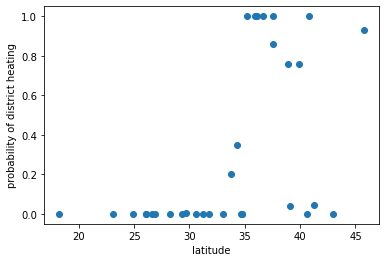

In [361]:
# scatter plot the probability of district heating across latitude
plt.scatter(df_city['latitude'], df_city['p_dh'])
plt.xlabel('latitude')
plt.ylabel('probability of district heating')

In [362]:
# print each city name using a for loop
for i in range(len(df_city)):
    if i >= 10:
        cityname = df_city['city'][i]
        print(cityname)
        print(df_city['p_dh'][i])
        print(df[df['city'] == cityname]['heating_type'].value_counts())
        print(df[df['city'] == cityname]['building_type'].value_counts())
        print("***************************************\n")
        print()

HubeiWuhan
0.0
Naturally Ventilated    526
Name: heating_type, dtype: int64
Dormitory       348
Residential      95
Educationnal     83
Name: building_type, dtype: int64
***************************************


Shanghai
0.0
Convection heating               784
Radiant floor heating            726
Naturally Ventilated             390
Air conditioning heating         200
Small electric heater heating     23
Others                             8
Name: heating_type, dtype: int64
Office         906
Residential    858
Educational    315
Dormitory       52
Name: building_type, dtype: int64
***************************************


JiangsuChangzhou
0.0
Ceiling capillary heating    144
Name: heating_type, dtype: int64
Residential    144
Name: building_type, dtype: int64
***************************************


HenanNanyang
0.0
Naturally Ventilated        155
Air conditioning heating     96
Name: heating_type, dtype: int64
Residential    251
Name: building_type, dtype: int64
*******************

In general, the "Radiator heating" should indicate central heating systems.</br>
However, for Northern cities, the "Raidiant floor heating", "Floor radiation + fan coil" should also indicate central heating systems.

In [363]:
# Include Radiant floor heating as central heating
df_city.loc[df_city['city'] == "ShaanxiXi'an", 'p_dh'] = (594+585) / 1686
# Include Radiant floor heating as central heating
df_city.loc[df_city['city'] == "HenanZhengzhou", 'p_dh'] = 4 / 96
# Include Radiant floor heating as central heating
df_city.loc[df_city['city'] == 'LiaoningDalian', 'p_dh'] = (1292+67) / (1292+278+67+58+8)
# Include (floor heating + fan coil) as central heating
df_city.loc[df_city['city'] == 'Tianjin', 'p_dh'] = (684+31)/(684+31+15)
# Wrong data, http://dx.doi.org/10.1016/j.enbuild.2015.12.053
df_city.loc[df_city['city'] == 'Baotou', 'p_dh'] = 1
# Include Radiant floor heating as central heating
df_city.loc[df_city['city'] == 'LiaoningBenxi', 'p_dh'] = 1
# Include Radiant floor heating as central heating
df_city.loc[df_city['city'] == 'HeilongjiangHarbin', 'p_dh'] = 1

Text(0, 0.5, 'probability of district heating')

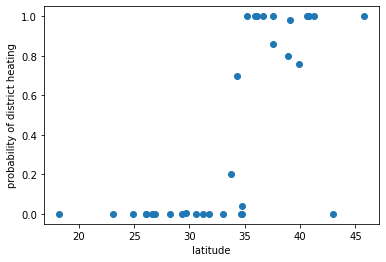

In [364]:
# scatter plot the probability of district heating across latitude
plt.scatter(df_city['latitude'], df_city['p_dh'])
plt.xlabel('latitude')
plt.ylabel('probability of district heating')

## Export CSV

In [365]:
# for all values in df_city, only keep two decimal places
df_city = df_city.round(2)
# save the df_city to a csv file
df_city.to_csv('CN_DB_CITY.csv', index=False)

In [366]:
df_city

,city,records,tsv,tcv,tav,ta,ta_std,twb,twb_std,rh,...,clo_std,top,tg,tr,tr_std,t_out,latitude,tsr,tn_op,p_dh
0,HainanSanya,5,0.60,1.60,0.42,24.88,1.24,20.84,0.82,70.20,...,0.09,24.88,24.88,24.88,1.24,NaN,18.25,0.80,23.38,0.00
1,GuangdongGuangzhou,997,-0.01,1.38,0.46,23.85,1.08,17.40,1.54,52.94,...,0.22,23.88,23.88,23.90,1.11,16.71,23.13,0.90,23.91,0.00
2,YunnanKunming,415,-1.15,1.42,0.69,13.62,3.12,4.41,3.79,16.95,...,0.25,13.62,19.22,13.62,3.12,NaN,24.87,0.66,16.50,0.00
3,FujianFuzhou,7,-0.71,1.57,0.33,18.10,1.53,14.23,2.01,67.43,...,0.17,18.10,18.10,18.10,1.53,NaN,26.08,0.86,19.89,0.00
4,FujianZhenjiang,2,-0.50,1.50,0.55,22.90,2.26,19.55,2.05,74.50,...,0.33,22.90,22.90,22.90,2.26,NaN,26.10,0.50,24.15,0.00
5,FujianNanping,4,0.00,1.00,0.32,17.90,1.24,13.15,1.32,60.25,...,0.10,17.90,17.90,17.90,1.24,NaN,26.64,1.00,17.90,0.00
6,HunanHengyang,1,-1.00,2.00,-0.10,16.90,NaN,12.90,NaN,66.00,...,NaN,16.90,16.90,16.90,NaN,NaN,26.89,1.00,19.40,0.00
7,HunanChangsha,1108,-0.40,2.82,0.41,17.22,3.28,11.00,2.61,48.35,...,0.41,17.41,18.20,17.59,2.96,NaN,28.23,0.89,18.40,0.00
8,SichuanZigong,23,-0.22,1.61,0.64,11.03,1.30,7.56,1.00,66.52,...,0.27,11.03,11.03,11.03,1.30,NaN,29.34,0.78,11.57,0.00
9,Lhasa,355,-1.10,NaN,NaN,10.64,4.03,7.66,3.97,71.19,...,0.23,10.64,10.64,10.64,4.03,NaN,29.65,0.64,13.38,0.01
